---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='red'> Student Names: Rohan Crawley, Eros Vincenzo Furina </font></div>
## <div align="center"> <font color='red'> Student numbers: s400045, s4004170 </font></div>
---

# Introduction
## Introduction
We have chosen to tackle project 1 (Classify Images of Colon Cancer) for our assignment.

# Load Data


In [1]:
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

if not os.path.exists('data_labels_extraData.csv'):
    with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    print('Data extracted successfully')
else:
    print('Data previously extracted')

main_data = pd.read_csv('./data_labels_mainData.csv')
extra_data = pd.read_csv('./data_labels_extraData.csv')
print("Main data : {}, Extra Data: {}".format(main_data.shape, extra_data.shape))

Data previously extracted
Main data : (9896, 6), Extra Data: (10384, 4)


# Cancerous Cell Model

## Prepare Data and Split 

In [2]:
# As there is an isCancerous column for both datasets
# We will join them for this model
data = pd.concat([extra_data, main_data], axis=0, ignore_index=True) # concatenating along rows
data = data.drop(columns=['cellTypeName', 'cellType']) # Drop unnecessary columns
# Split into train, test and val
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape, val_data.shape, test_data.shape))
display(train_data)
train_data.info()

Train data : (12168, 4), Val Data: (4056, 4), Test Data: (4056, 4)


,InstanceID,patientID,ImageName,isCancerous
233,18792,63,18792.png,0
17678,3280,46,3280.png,1
2371,6956,71,6956.png,0
5032,2919,80,2919.png,1
9768,21702,92,21702.png,0
...,...,...,...,...
18424,3378,51,3378.png,0
1897,6656,69,6656.png,0
3995,10620,79,10620.png,0
6833,9608,86,9608.png,0


<class 'pandas.core.frame.DataFrame'>
Index: 12168 entries, 233 to 17480
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   12168 non-null  int64 
 1   patientID    12168 non-null  int64 
 2   ImageName    12168 non-null  object
 3   isCancerous  12168 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 475.3+ KB


## EDA


Missing Values:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64

Unique Classes:
[0 1]

Class Distribution in Train Data:


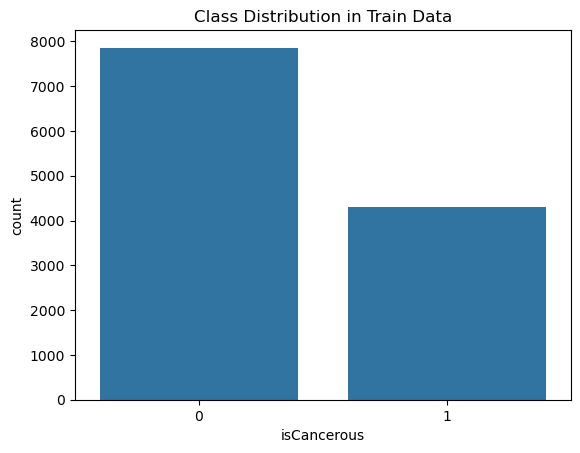

Total non-cancerous: 7857. Total cancerous: 4311. Ratio of non-cancerous to cancerous: 1.8225469728601253


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for null values
print("\nMissing Values:")
print(train_data.isnull().sum())

# Check unique labels
print("\nUnique Classes:")
print(train_data['isCancerous'].unique())

print("\nClass Distribution in Train Data:")
sns.countplot(x='isCancerous', data=train_data)
plt.title('Class Distribution in Train Data')
plt.show()

counts = train_data['isCancerous'].value_counts()
num_cancerous = counts.get(1, 0)
num_non_cancerous = counts.get(0, 0)  
ratio = (num_non_cancerous * 1.0) / (num_cancerous * 1.0)
print("Total non-cancerous: {}. Total cancerous: {}. Ratio of non-cancerous to cancerous: {}".format(num_non_cancerous, num_cancerous, ratio)) 

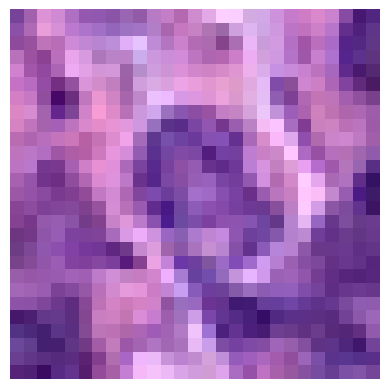

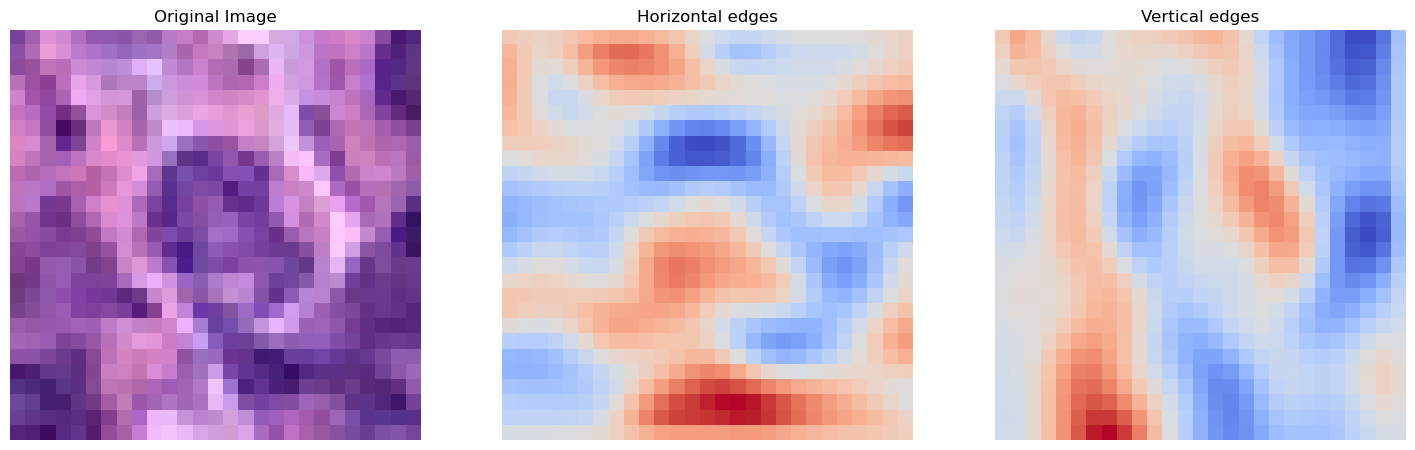

In [4]:
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage import filters
from skimage.color import rgb2gray
from skimage.filters import gaussian



# plt.figure(figsize=(10, 10))
# for i in range(9):
#     imageName = train_data[i]
    
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

image = imread('patch_images/4000.png', as_gray=False, plugin=None)
# Plot image
plt.imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()


grayscale = rgb2gray(image)
smooth_image_1 = gaussian(grayscale, sigma=2)
edge_sobel_h = filters.sobel_h(smooth_image_1)
edge_sobel_v = filters.sobel_v(smooth_image_1)

# Plot image
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(edge_sobel_h, cmap=plt.cm.coolwarm)
plt.axis('off')
plt.title("Horizontal edges")
plt.subplot(1,3,3)
plt.imshow(edge_sobel_v, cmap=plt.cm.coolwarm)
plt.axis('off')
plt.title("Vertical edges")
plt.show()

## EDA Discussion & Approach to Base Model

We can see a class imbalance, with a 

One good reason to choose a CNN is because we are not experts in histeopathology, and so, if we were to do manual feature selection, we would not know what the correct features would be.

## Set Up Base Model

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,  
        class_mode='binary')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)

# Define input shape based on 27x27 RGB images
input_shape = (27, 27, 3)

# Build a simple base CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.metrics.AUC(name='auc')]
)

# Display model summary
model.summary()


C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 27, 27, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,457 (1.20 MB)

 Trainable params: 315,009 (1.20 MB)

 Non-trainable params: 448 (1.75 KB)

## Train Model

In [7]:
epochs = 50
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

C:\Users\rohan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 195s 502ms/step - accuracy: 0.8057 - auc: 0.8772 - loss: 0.4474 - val_accuracy: 0.6824 - val_auc: 0.8086 - val_loss: 1.4647
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.8729 - auc: 0.9362 - loss: 0.3070 - val_accuracy: 0.5323 - val_auc: 0.9280 - val_loss: 1.0668
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8774 - auc: 0.9402 - loss: 0.2942 - val_accuracy: 0.8802 - val_auc: 0.9536 - val_loss: 0.2965
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8814 - auc: 0.9478 - loss: 0.2749 - val_accuracy: 0.8955 - val_auc: 0.9558 - val_loss: 0.2556
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8838 - auc: 0.9506 - loss: 0.2685 - val_accuracy: 0.8785 - val_auc: 0.9498 - val_loss: 0.2856
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8897 - auc: 0.9504 - loss: 0.2668 - val_accuracy: 0.7700 - val_auc: 0.9285 - val_loss: 0.6832
Epoch 7/50
381/381 ━━━━━━━

## Plot Results

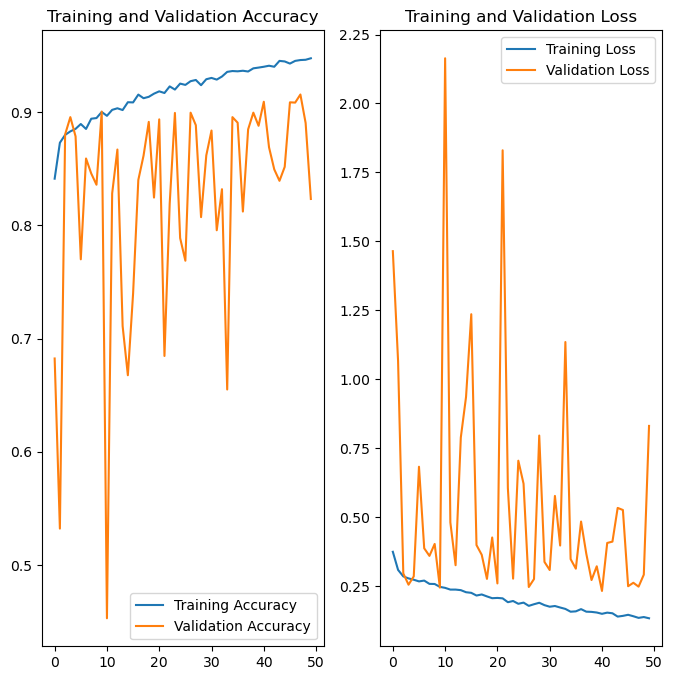

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Independant Evaluation
...

# Appendix
...